In [1]:
# import rozneho potrebneho...

%load_ext autoreload
%autoreload

%matplotlib nbagg

import numpy as np
from scipy.integrate import odeint

import sys
sys.path.append('./misc/')

from figFcns_nb import *

# Algoritmus RMNŠ pri zašumených dátach

V predchádzajúcom bola vytvorená simulačná schéma pre simuláciu uvažovaného riadeného systému a bol do nej doplnený algoritmus RMNŠ.

Výstupná veličina samotného simulovaného riadeného systému je, pochopiteľne, bez šumu. Tu je cieľom preskúmať ako je RMNŠ schopný vysporiadať sa z prítomnosťou šumu dátach výstupnej veličiny.

Funkcia, ktorá realizuje diferenciálne rovnice riadeného systému imporotovaná tu:

In [2]:
import plantFcns

Simulačnú schému nech realizuje nasledujúca funkcia:

In [3]:
# Simulacna schema:

def fcn_simSch_02_lenRMNS_noise(t_start, T_s, finalIndex, sig_u_ext, lambdaKoef):

    #-----------------------------------------
    t_log = np.zeros([finalIndex, 1])
    t_log[0,:] = t_start

    #-----------------------------------------
    x_0 = np.array([0, 0])

    x_log = np.zeros([finalIndex, len(x_0)])
    x_log[0,:] = x_0


    y_log_noise = np.zeros([finalIndex, 1])
    y_log_noise[0,0] = x_log[0,0]

    #-----------------------------------------

    u_log = np.zeros([finalIndex, 1])

    #-----------------------------------------

    RMNS_theta_0 = np.array([[ 0.001],
                             [ 0.001],
                             [ 0.001],
                             [ 0.001]])


    RMNS_theta_log = np.zeros([finalIndex, len(RMNS_theta_0)])
    RMNS_theta_log[0,:] = RMNS_theta_0.reshape(1,-1)


    RMNS_P_0 = np.identity(4) * 10**2

    RMNS_P_log = np.zeros([finalIndex, RMNS_P_0.size])
    RMNS_P_log[0,:] = RMNS_P_0.reshape(1,-1)


    RMNS_y_predict_log = np.zeros([finalIndex, 1])

    #-----------------------------------------



    #-----------------------------------------
    timespan = np.zeros(2)
    for idx in range(1, int(finalIndex)):

        timespan[0] = t_log[idx-1,:]
        timespan[1] = t_log[idx-1,:] + T_s

        odeOut = odeint(plantFcns.fcn_difRovnice,
                        x_log[idx-1,:],
                        timespan,
                        args=(u_log[idx-1,:],)
                        )

        x_log[idx,:] = odeOut[-1,:]
        t_log[idx,:] = timespan[-1]
        
        
        # Tu sa umelo pridava sum k vystupnej velicine riadeneho systemu

        y_log_noise[idx,0] = x_log[idx,0] + np.random.normal(0, 0.1, size=1)


        #--------------------
        # ALGORITMUS RMNS
        
        # Pri RMNS sa vyuziva „zasimena“ vystupna velicina
        
        y_k = y_log_noise[idx,0]

        h_k = np.array([[-y_log_noise[idx-1,0]],
                        [-y_log_noise[idx-2,0]],
                        [u_log[idx-1,0]],
                        [u_log[idx-2,0]],
                        ])


        theta_km1 = RMNS_theta_log[idx-1,:].reshape(4,-1)
        P_km1 = RMNS_P_log[idx-1,:].reshape(4,4)

        #----------
        e_k = y_k - np.matmul(h_k.T, theta_km1)
        Y_k =  np.matmul(P_km1, h_k) / (lambdaKoef + np.matmul(np.matmul(h_k.T, P_km1), h_k))
        P_k = (1/lambdaKoef) * (P_km1 - np.matmul(np.matmul(Y_k, h_k.T), P_km1))
        theta_k = theta_km1 + Y_k * e_k

        #----------
        RMNS_theta_log[idx,:] = theta_k.reshape(1,-1)
        RMNS_P_log[idx,:] = P_k.reshape(1,-1)

        RMNS_y_predict_log[idx,:] = np.matmul(h_k.T, theta_km1)

        #--------------------
        u_log[idx,:] = sig_u_ext[idx-1,:]



    return [t_log, x_log, RMNS_y_predict_log, RMNS_theta_log, y_log_noise]

V uvedenej simulačnej schéme je implementovaný RMNŠ algoritmus, ktorého výstupom je vektor parametrov ```theta_k``` a následne je tiež vypočítaná (v každom cykle) jednokroková predikcia výstupného signálu zapisovaná do vektora ```RMNS_y_predict_log```.

Všimnime si tiež napríklad, že faktor zabúdania $\lambda$ (premenná ```lambdaKoef```) je nastavený na hodnotu $\lambda = 1$, teda algoritmus nevyužíva zabúdanie.

Nastavenia potrebné pre samotnú simuláciu a vygenerovanie signálov, ktoré sa používajú pri simulácii (ktoré sú dopredu známe - dané):

In [4]:
# Nastavenia simulacie

sim_t_start = 0
sim_t_final = 500
sim_T_s = 0.1
sim_finalIndex = int(((sim_t_final - sim_t_start)/sim_T_s) + 1)

Pre simuláciu je potrebné vytvoriť vstupný signál $u(t)$ pre riadený systém. Nech je nasledovný:

In [5]:
# Preddefinovane signaly

period_time = 200
period_tab = np.array([
                      [0, 1],
                      [50, 0],
                      [100, -1],
                      [150, 0],
                      ])

sig_vysl = np.zeros([sim_finalIndex, 1])

for period in range(int(sim_t_final/period_time) + 1):


    for idx in range( int((period*period_time)/sim_T_s), int((period*period_time + period_time)/sim_T_s)):

        lastValue = period_tab[:,1][(period_tab[:,0] + (period*period_time))<=idx*sim_T_s ][-1]
        try:
            sig_vysl[idx] = lastValue
        except:
            break


sig_u_ext = sig_vysl

Ďalším nastavením, špeciálne dôležitým v tomto príklade je koeficient zabúdania $\lambda$:

In [6]:
sim_lambdaKoef = 1.0

V tomto prípade sa teda zabúdanie neuvažuje.

Spustenie simulácie:

In [7]:
# Spustenie simulacie

t_log, x_log, RMNS_y_predict_log, RMNS_theta_log, y_log_noise = fcn_simSch_02_lenRMNS_noise(
    sim_t_start,
    sim_T_s,
    sim_finalIndex,
    sig_u_ext,
    sim_lambdaKoef
    )

Nakreslenie obrázku (pre prehľadnosť tohto notebooku je kód v samostatnom súbore):

<IPython.core.display.Javascript object>


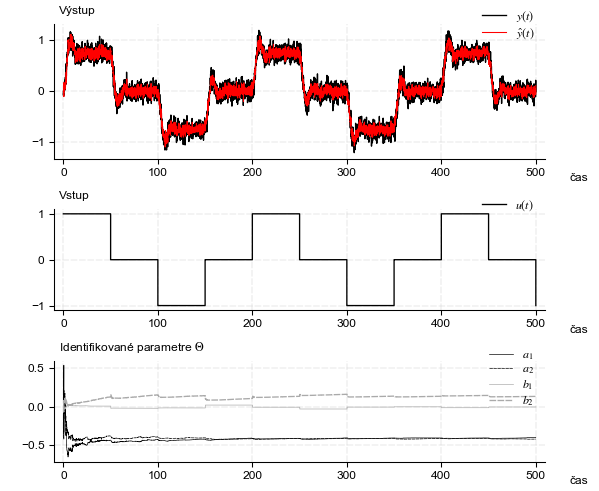

In [8]:
figNameNum = 1
execfile('misc/v_fig_lenRMNS_noise.py')

Iná simulácia nech je s nasledovným koeficientom zabúdania:

<IPython.core.display.Javascript object>


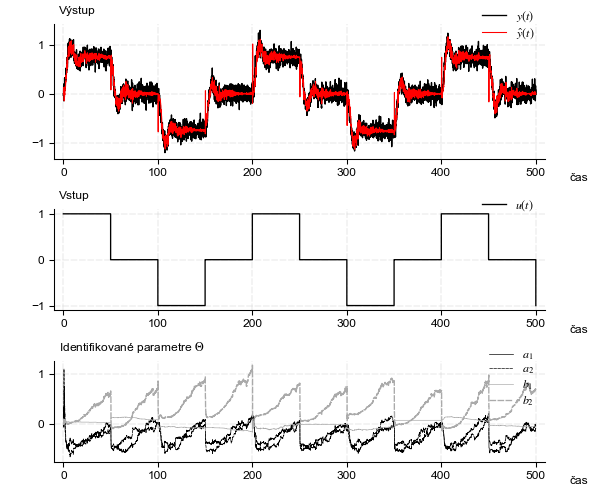

In [9]:
sim_lambdaKoef = 0.985

# Spustenie simulacie

t_log, x_log, RMNS_y_predict_log, RMNS_theta_log, y_log_noise = fcn_simSch_02_lenRMNS_noise(
    sim_t_start,
    sim_T_s,
    sim_finalIndex,
    sig_u_ext,
    sim_lambdaKoef
    )

figNameNum = 2
execfile('misc/v_fig_lenRMNS_noise.py')

Extrémnou voľbou koeficientu zabúdania pre tento prípad by bolo:

<IPython.core.display.Javascript object>


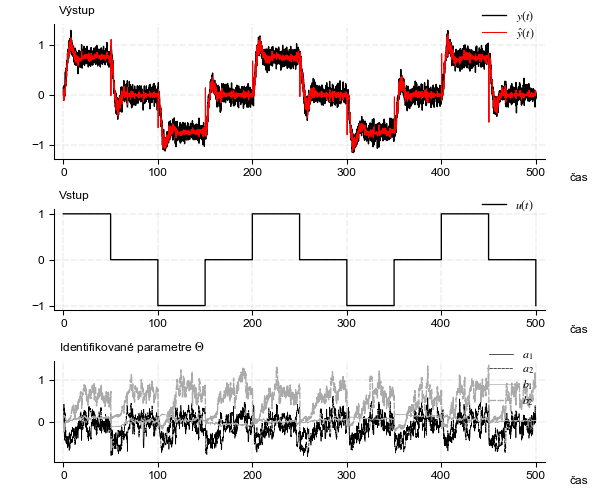

In [10]:
sim_lambdaKoef = 0.935

# Spustenie simulacie

t_log, x_log, RMNS_y_predict_log, RMNS_theta_log, y_log_noise = fcn_simSch_02_lenRMNS_noise(
    sim_t_start,
    sim_T_s,
    sim_finalIndex,
    sig_u_ext,
    sim_lambdaKoef
    )

figNameNum = 3
execfile('misc/v_fig_lenRMNS_noise.py')